This notebook follows instructions from mlzoomcamp 2022 and is admitted as capstone project: https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/08-deep-learning/notebook.ipynb

Problem statement: There are different entities of skin cancer. The HAM10000 is a collection of skin lesion images. Identifying the type of skin lesion is challenging. This project applies neural network techniques to classify the images. 

***Disclaimer: This work is part of an educational project. It is not intended for clinical application. As such it can not make real world predictions for skin lesions. To get recommendations regarding skin lesions one should ask for expert advice such as provided by a dermatologist.***

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [4]:
import os
for dirname, _, filenames in os.walk('../input'):
    print(dirname, len(filenames))
    print(*filenames[:3])

../input 0

../input/skin-cancer-mnist-ham10000 5
hmnist_8_8_RGB.csv hmnist_28_28_RGB.csv hmnist_8_8_L.csv
../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1 5000
ISIC_0028933.jpg ISIC_0028394.jpg ISIC_0027799.jpg
../input/skin-cancer-mnist-ham10000/ham10000_images_part_1 5000
ISIC_0028933.jpg ISIC_0028394.jpg ISIC_0027799.jpg
../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2 5015
ISIC_0030912.jpg ISIC_0030585.jpg ISIC_0033697.jpg
../input/skin-cancer-mnist-ham10000/ham10000_images_part_2 5015
ISIC_0030912.jpg ISIC_0030585.jpg ISIC_0033697.jpg


In [7]:
path = '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
name = os.listdir(path)[0]
fullname = f'{path}/{name}'
print(fullname)
img = load_img(fullname, target_size=(299, 299))
x = np.array(img)
print(x.shape)

../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
(299, 299, 3)


In [8]:
metadata = pd.read_csv("../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

df_img = pd.DataFrame()
df_img["img_file"] = [img_name+".jpg" for img_name in metadata.image_id]
df_img["dx"] = list(metadata.dx)

train_ds = train_gen.flow_from_dataframe(
    df_img,
    directory="../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    x_col="img_file",
    y_col="dx",
    target_size=(150, 150),
    batch_size=32
)

Found 5000 validated image filenames belonging to 7 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5015 invalid image filename(s) in x_col="img_file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [10]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_dataframe(
    df_img,
    directory="../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2",
    x_col="img_file",
    y_col="dx",
    target_size=(150, 150),
    batch_size=32
)

Found 5015 validated image filenames belonging to 7 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5000 invalid image filename(s) in x_col="img_file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [11]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(7)(vectors)
model = keras.Model(inputs, outputs)

2022-11-22 12:51:46.672069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 12:51:46.838193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 12:51:46.838999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 12:51:46.840360: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


In [13]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [18]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10
157/157 [==============================] - 125s 798ms/step - loss: 0.5959 - accuracy: 0.8084 - val_loss: 1.3008 - val_accuracy: 0.6461


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
157/157 [==============================] - 124s 795ms/step - loss: 0.5604 - accuracy: 0.8160 - val_loss: 1.4453 - val_accuracy: 0.6164
Epoch 3/10
157/157 [==============================] - 124s 790ms/step - loss: 0.4517 - accuracy: 0.8466 - val_loss: 1.4109 - val_accuracy: 0.6931
Epoch 4/10
157/157 [==============================] - 128s 815ms/step - loss: 0.4384 - accuracy: 0.8486 - val_loss: 1.4538 - val_accuracy: 0.6594
Epoch 5/10
157/157 [==============================] - 126s 804ms/step - loss: 0.3409 - accuracy: 0.8806 - val_loss: 1.5358 - val_accuracy: 0.6776
Epoch 6/10
157/157 [==============================] - 125s 798ms/step - loss: 0.3333 - accuracy: 0.8786 - val_loss: 1.4943 - val_accuracy: 0.6423
Epoch 7/10
157/157 [==============================] - 124s 791ms/step - loss: 0.3387 - accuracy: 0.8818 - val_loss: 1.5733 - val_accuracy: 0.6989
Epoch 8/10
157/157 [==============================] - 126s 806ms/step - loss: 0.3826 - accuracy: 0.8744 - val_loss: 1.6152 -

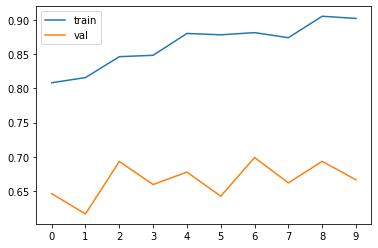

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [20]:
! pip install huggingface_hub

In [32]:
from huggingface_hub import notebook_login
notebook_login()

In [22]:
model = keras.models.load_model('xception_v4_1_07_0.699.h5')

In [23]:
model.push_to_hub("bsenst/skin-cancer-HAM10k")

AttributeError: 'Functional' object has no attribute 'push_to_hub'

In [39]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 93 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 0s (7872 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 108827 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.9.2-1_amd64.deb ...
Unpacking git-lfs (2.9.2-1) ...
Setting up git-lfs (2.9.2-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [40]:
!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [41]:
from huggingface_hub import Repository

repo = Repository("hfrepo", clone_from="bsenst/skin-cancer-HAM10k")

Cloning https://huggingface.co/bsenst/skin-cancer-HAM10k into local empty directory.


In [42]:
! cp xception_v4_1_07_0.699.h5 hfrepo/xception_v4_1_07_0.699.h5

In [43]:
repo.git_add()
repo.git_commit()
repo.git_push()

Upload file xception_v4_1_07_0.699.h5:   0%|          | 32.0k/80.0M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/bsenst/skin-cancer-HAM10k
   9ffe029..ce0c0b0  main -> main



'https://huggingface.co/bsenst/skin-cancer-HAM10k/commit/ce0c0b027420e1db648aebcef6fdcef5a95eb665'